# Kaggle: Plant Pathology 2021 - FGVC8

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Borda/kaggle_image-classify/blob/main/notebooks/Plant-Pathology-with-Flash.ipynb)

## Setup environment 

- connect the gDrive with dataset
- extract data to local
- install pytorch lightning

In [1]:
! pip install -q lightning-flash[image]
! pip list | grep torch
! pip list | grep lightning

efficientnet-pytorch              0.6.3
pytorch-lightning                 1.5.10
segmentation-models-pytorch       0.2.1
torch                             1.10.2
torchaudio                        0.10.2
torchmetrics                      0.7.2
torchvision                       0.11.3
torchviz                          0.0.2
lightning-bolts                   0.5.0
lightning-flash                   0.7.1
lightning-grid                    0.8.30
pytorch-lightning                 1.5.10


In [2]:
! nvidia-smi -L

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-c5a9157d-2b40-a8f4-46da-4169858059ee)


## Data exploration

Checking what data do we have available and what is the labels distribution...

Looking in the training dataset table, what colums and what is the data representation...

In [3]:
%matplotlib inline

import os
from pprint import pprint

import pandas as pd

base_path = "/home/jovyan/datastores/kaggle_image-classify"
path_csv = os.path.join(base_path, "train.csv")
train_data = pd.read_csv(path_csv)
display(train_data.head())

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


We can see that each image can have multiple labels so lets check what is the mos common label count...

*The target classes, a space delimited list of all diseases found in the image.
Unhealthy leaves with too many diseases to classify visually will have the complex class, and may also have a subset of the diseases identified.*

In [4]:
import numpy as np

train_data["nb_classes"] = [len(lbs.split(" ")) for lbs in train_data["labels"]]
lb_hist = dict(zip(range(10), np.bincount(train_data["nb_classes"])))
pprint(lb_hist)

{0: 0, 1: 17277, 2: 1155, 3: 200}


Browse the label distribution, enrolling all labels in the dataset, so in case an image has two labels both are used in this stat...

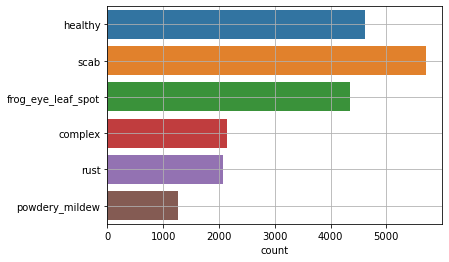

In [5]:
import itertools

import seaborn as sns

labels_all = list(itertools.chain(*[lbs.split(" ") for lbs in train_data["labels"]]))
train_data["labels_sorted"] = [" ".join(sorted(lbs.split(" "))) for lbs in train_data["labels"]]

ax = sns.countplot(y=labels_all, orient="v")
ax.grid()

## Flash finetuning

See example in https://lightning-flash.readthedocs.io/en/stable/reference/image_classification_multi_label.html

In [6]:
import flash
import torch
from flash.image import ImageClassificationData, ImageClassifier

In [7]:
# from tqdm.auto import tqdm

# labels_uq = set(labels_all)
# print(labels_uq)

# train_ = []
# for idx, row in tqdm(train_data.iterrows(), total=len(train_data)):
#     row = dict(row)
#     row.update({lb: 1 for lb in row["labels"].split(" ")})
#     train_.append(row)

# train_data = pd.DataFrame(train_).fillna(0).astype({lb: "int64" for lb in labels_uq})
# display(train_data.head())

### 1. Load the data

In [8]:
datamodule = ImageClassificationData.from_data_frame(
    "image",
    # list(labels_uq),
    "labels",
    train_data_frame=train_data,
    train_images_root=os.path.join(base_path, "train_images"),
    transform_kwargs={"image_size": (384, 384)},
    batch_size=28,
    num_workers=6,
    val_split=0.2,
)
print(datamodule.multi_label)

True


### 2. Build the model

In [9]:
model = ImageClassifier(
    backbone="tf_efficientnet_b4_ns",
    optimizer=torch.optim.AdamW,
    learning_rate=0.005,
    labels=datamodule.labels,
    multi_label=datamodule.multi_label,
)

Using 'tf_efficientnet_b4_ns' provided by rwightman/pytorch-image-models (https://github.com/rwightman/pytorch-image-models).
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b4_ns-d6313a46.pth" to /home/jovyan/.cache/torch/hub/checkpoints/tf_efficientnet_b4_ns-d6313a46.pth


### 3. Create the trainer

In [10]:
import pytorch_lightning as pl

logger = pl.loggers.CSVLogger(save_dir="logs/")
trainer = flash.Trainer(
    gpus=1,
    logger=logger,
    max_epochs=10,
    precision=16,
    val_check_interval=0.5,
    progress_bar_refresh_rate=1,
)

Using 16bit native Automatic Mixed Precision (AMP)
/home/jovyan/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:90: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=1)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


### 4. Train the model

In [ ]:
trainer.finetune(model, datamodule=datamodule, strategy=("freeze_unfreeze", 1))

# Save it!
trainer.save_checkpoint("image_classification_model.pt")

Quick visualization of the training process...

In [12]:
# # Start tensorboard.
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

,train_f1score_step,train_binary_cross_entropy_with_logits_step,val_f1score,val_binary_cross_entropy_with_logits,train_f1score_epoch,train_binary_cross_entropy_with_logits_epoch
epoch,,,,,,
0,0.588235,0.295157,NaN,NaN,NaN,NaN
0,0.700000,0.226590,NaN,NaN,NaN,NaN
0,0.813559,0.182814,NaN,NaN,NaN,NaN
0,0.750000,0.190468,NaN,NaN,NaN,NaN
0,0.862069,0.155587,NaN,NaN,NaN,NaN


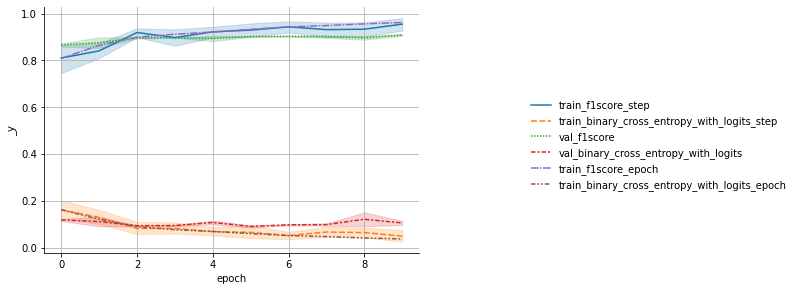

In [13]:
import matplotlib.pyplot as plt
import seaborn as sn

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
g = sn.relplot(data=metrics, kind="line")
plt.gcf().set_size_inches(12, 4)
plt.grid()